In [24]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [25]:
def buildTrain(train, pastDay=5, futureDay=1):
    X_train, Y_train ,Z_train= [], [],[]
    for i in range(train.shape[0]-futureDay-pastDay+1):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["high"]))
        Z_train.append(np.array(train.iloc[i+pastDay-1:i+pastDay+futureDay-1]["high"]))
    return np.array(X_train), np.array(Y_train), np.array(Z_train)
def shuffle(X,Y,Z):
    np.random.seed()
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList],Z[randomList]
def splitData(X,Y,Z,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    Z_val = Z[:int(Z.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val,Z_val

In [26]:
train = pd.read_csv(r"C:\Users\admin\Desktop\Project\data\台北一\蔬果\奇異果-進口.csv")
train=train.drop(["Unnamed: 0"], axis=1)
train=train.drop(["crop_name"], axis=1)
train=train.drop(["crop_num"], axis=1)
train=train.drop(["market_name"], axis=1)
train=train.drop(["market_num"], axis=1)
temp=train
train= train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
train_x1,train_y1,train_z1=buildTrain(train)
train_x2,train_y2,train_z2=buildTrain(temp)
train_x,train_y,train_z=train_x1,train_y2,train_z2
train_x,train_y,train_z= shuffle(train_x,train_y,train_z)
train_x,train_y, val_x, val_y ,val_z= splitData(train_x,train_y,train_z, 0.075)

In [27]:
model = Sequential()
model.add(LSTM(150, input_length=train_x.shape[1],input_dim= train_x.shape[2],return_sequences=True))
model.add(Dropout(0.35))
model.add(LSTM(50))
model.add(Dropout(0.35))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x,train_y, epochs=300, batch_size=16, validation_split=0.1, callbacks=[callback])

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(150, return_sequences=True, input_shape=(5, 9))`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 5, 150)            96000     
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 150)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                40200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 136,251
Trainable params: 136,251
Non-trainable params: 0
_________________________________________________________________
Trai

1776/1776 [==============================] - 1s 427us/step - loss: 966.2519 - val_loss: 461.6621
Epoch 65/300
1776/1776 [==============================] - 1s 436us/step - loss: 972.8723 - val_loss: 456.7076
Epoch 66/300
1776/1776 [==============================] - 1s 456us/step - loss: 981.0197 - val_loss: 465.1451
Epoch 67/300
1776/1776 [==============================] - 1s 453us/step - loss: 955.5088 - val_loss: 458.1410
Epoch 68/300
1776/1776 [==============================] - 1s 455us/step - loss: 954.5004 - val_loss: 483.2107
Epoch 69/300
1776/1776 [==============================] - 1s 450us/step - loss: 958.9477 - val_loss: 464.8212
Epoch 00069: early stopping


accuracy:59.375%
accuracy(50%):25.624999999999996%


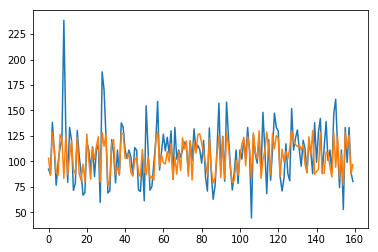

In [28]:
a=range(0,val_y.shape[0])
val_y=val_y.reshape(-1)
val_z=val_z.reshape(-1)
plt.plot(a,val_y)
b=[]
co=0
coo=0
for i in range(0,val_x.shape[0]):
    temp=val_x[i]
    temp=temp.reshape(1,5,9)
    z=model.predict(temp, verbose=0)
    if val_y[i]>=val_z[i] and z>=val_z[i]:
        co=co+1
    if val_y[i]<val_z[i] and z<val_z[i]:
        co=co+1
    sub=val_y[i]-val_z[i]
    sub_a=0.5*sub+val_z[i]
    sub_b=1.5*sub+val_z[i]
    sub2=val_z[i]-val_y[i]
    sub2_a=val_z[i]-0.5*sub2
    sub2_b=val_z[i]-1.5*sub2
    if val_y[i]>=val_z[i] and z>=val_z[i]:
        if z>=sub_a and z<=sub_b:
            coo=coo+1
    if val_y[i]<val_z[i] and z<val_z[i]:
        if z<=sub2_a and z>=sub2_b:
            coo=coo+1
    b.append(z)
b=np.array(b)
b=b.reshape(-1)
plt.plot(a,b)
acc=100*(co/val_x.shape[0])
print("accuracy:"+str(acc)+"%")
acc2=100*(coo/val_x.shape[0])
print("accuracy(50%):"+str(acc2)+"%")
plt.show()

In [17]:
print(temp.shape)

(1, 10, 9)


In [21]:
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
print(val_z.shape)

(1970, 10, 9)
(1970, 1)
(159, 10, 9)
(159,)
(159,)
